# Google Drive

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

KeyboardInterrupt: ignored

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

name 'take_photo' is not defined


# Importar librerias

In [ ]:
!python

Python 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> 
KeyboardInterrupt
>>> 
KeyboardInterrupt
>>> ^C


In [ ]:
from os import listdir, getcwd
from os.path import isfile, join

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model,to_categorical

# Navegando el conjunto de datos

In [ ]:
files_path = "../content/drive/MyDrive/Universidad/8vo cuatrimestre/Sistemas inteligentes/Evidencias/Conjunto de datos/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files"

In [ ]:
class Diagnosis():
    """Representar un diagnostico, con la ubicación del audio y su diagnostico.

    Args:
        id: Identificador entero.
        diagnosis: Cadena que es el diagnositco del archivo de audio.
        path: Cadena concatenada que es la ruta del archivo .wav 
    """

    def __init__ (self, id, diagnosis, path):
      self.id = id
      self.diagnosis = diagnosis 
      self.path = path

In [ ]:
def get_audio_files(files_path):
    """Retornar una lista de todos los archivos de audio del conjunto de datos.

    Se lista el directorio de "file_path" y se agrega a una lista todos 
    aquellos que seana archivos, posteriormente, para cada archivo se verifica
    si son .WAV y se agrega a una lista.

    Args:
      files_path: Directorio donde se encuentran los archivos del conjunto de 
        datos.

    Returns:
      sorted_files: Lista ordenada alfabeticamente de los archivos .wav.
    """
    files = [f for f in listdir(files_path) if isfile(join(files_path, f))]
    wav_files = [f for f in files if f.endswith('.wav')]  

    sorted_files = sorted(wav_files)
    return sorted_files

In [ ]:
def diagnosis_data(files_path):
    """Crear lista de las instancias de la clase Diagnosis con los atributos.

    Crear diccionario de los diagnosticos a partir de  'patient_diagnosis.csv',
    asignarlo a cada archivo obtenido de get_audio_files() mediante una
    instancia de 'Diagnosis' y retornar todas estás instancias en una lista.

    Args:
      files_path: Directorio donde se encuentran los archivos del conjunto de 
      datos.

    Returns:
      diagnosis_list: Lista de las instancias de la clase Diagnosis con sus 
      atributos
    """
    diagnosis = pd.read_csv("../content/drive/MyDrive/Universidad/8vo cuatrimestre/Sistemas inteligentes/Evidencias/Conjunto de datos/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv")
    wav_files = get_audio_files(files_path)
    diag_dict = {101: "URTI"}  
    diagnosis_list = []
    
    for index, row in diagnosis.iterrows():
      diag_dict[row[0]] = row[1]     

    id = 0
    for f in wav_files:
      diagnosis_list.append(Diagnosis(id, diag_dict[int(f[:3])], 
                                      join(files_path, f)))  
      id += 1  

    return diagnosis_list

# Extracción de características

In [ ]:
def get_audio_features(filename): 
    """Extraer las características de un audio y las concatena en un arreglo.

    Cargar el audio con Librosa para posteriormente calcular el valor absoluto
    o el promedio de los datos númericos de la caracteristica correspondiente.

    Args:
      filename: La ruta relativa donde se encuentra el archivo de audio.

    Returns:
      features: Unión de una secuencia de arreglos de las características,
    """
    sound, sample_rate = librosa.load(filename)
    stft = np.abs(librosa.stft(sound))  
    mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate), axis=1)
    mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate), axis=1)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate), axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate), axis=1)
    features = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))
    return features

In [ ]:
def data_points(files_path):
    """Generar  arreglos con el id del diagnostico y características del audio.

    Crear dos ejes, uno que agregue un identificador personalizado de cada 
    diagnostico y uno con todas las características de cada archivo.

    Args:
      files_path: Directorio donde se encuentran los archivos del conjunto de 
      datos.

    Returns:
      np.array(labels): Lista de identificador de los diagnosticos de cada 
      archivo.
      np.array(images): Lista de las características de audio de cada archivo.
    """
    images = []
    labels = []
    to_hot_one = {"COPD": 0, "Healthy": 1, "URTI": 2, "Bronchiectasis": 3, "Pneumonia": 4, "Bronchiolitis": 5, "Asthma": 6, "LRTI": 7}
    
    for f in diagnosis_data(files_path):
      labels.append(to_hot_one[f.diagnosis]) 
      images.append(get_audio_features(f.path))

    return np.array(labels), np.array(images)

# Pre-procesamiento

In [ ]:
def preprocessing(labels, images):
    """Generar y procesar los datos de entrenamiento y prueba.

    Eliminar datos que tienen poca representación, dividir los restantes
    en los datos de entrenamiento y prueba, crear una matriz binaria y 
    redimensionar arreglos.

    Args:
      labels: Lista de identificador de los diagnosticos de cada archivo.
      images: Lista de las características de audio de cada archivo.

    Returns:
      x_train: Conjunto de datos de entrenamiento del eje x.
      x_test: Conjunto de datos de pruebas del eje x.
      y_train: Conjunto de datos de entrenamiento del eje y.
      y_test: Conjunto de datos de pruebas del eje y.
    """    
    images = np.delete(images, np.where((labels == 7) | (labels == 6))[0], axis=0) 
    labels = np.delete(labels, np.where((labels == 7) | (labels == 6))[0], axis=0)      
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=10)

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)  

    y_train = np.reshape(y_train, (y_train.shape[0], 6))
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 6))
    x_test = np.reshape(x_test, (x_test.shape[0], x_train.shape[1],  1))

    return x_train, x_test, y_train, y_test

In [ ]:
labels, images = data_points(files_path)
x_train, x_test, y_train, y_test = preprocessing(labels, images)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Red neuronal convolucional

In [ ]:
model = Sequential()

model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(193, 1)))
model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 
model.add(Conv1D(256, kernel_size=5, activation='relu'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))   
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=70, batch_size=200, verbose=1)

Epoch 1/70
4/4 [==============================] - 6s 1s/step - loss: 4.5457 - accuracy: 0.5807 - val_loss: 1.6897 - val_accuracy: 0.8098
Epoch 2/70
4/4 [==============================] - 4s 1s/step - loss: 1.8390 - accuracy: 0.6870 - val_loss: 0.9362 - val_accuracy: 0.8152
Epoch 3/70
4/4 [==============================] - 4s 1s/step - loss: 0.8021 - accuracy: 0.8123 - val_loss: 0.8473 - val_accuracy: 0.8370
Epoch 4/70
4/4 [==============================] - 4s 1s/step - loss: 0.7117 - accuracy: 0.8461 - val_loss: 0.5524 - val_accuracy: 0.8967
Epoch 5/70
4/4 [==============================] - 4s 1s/step - loss: 0.6074 - accuracy: 0.8578 - val_loss: 0.4624 - val_accuracy: 0.8967
Epoch 6/70
4/4 [==============================] - 4s 1s/step - loss: 0.5027 - accuracy: 0.8547 - val_loss: 0.4010 - val_accuracy: 0.8967
Epoch 7/70
4/4 [==============================] - 4s 1s/step - loss: 0.4689 - accuracy: 0.8539 - val_loss: 0.3525 - val_accuracy: 0.8967
Epoch 8/70
4/4 [=========================

# Evaluación

In [ ]:
score = model.evaluate(x_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

Accuracy: 96%
Loss: 0.1635



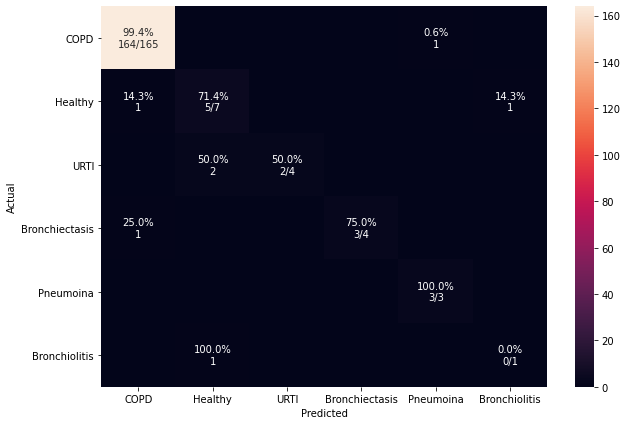

In [ ]:
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis"]

preds = model.predict(x_test)
classpreds = np.argmax(preds, axis=1) 
y_testclass = np.argmax(y_test, axis=1) 
cm = confusion_matrix(y_testclass, classpreds)
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape

for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df_cm, annot=annot, fmt='')

In [ ]:
import h5py

hf = h5py.File('data.h5', 'w')

hf.create_dataset('dataset_1', data=x_test)
hf.create_dataset('dataset_2', data=y_test)

<HDF5 dataset "dataset_2": shape (184, 6), type "<f4">